In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
df = pd.read_csv("all_seasons.csv")

Feature Creation:

In [ ]:
df['Awards'] = df['Awards'].fillna("")
df['Awards_List'] = df['Awards'].str.split(',')
df['Awards_List'] = df['Awards_List'].apply(lambda x: ["no_awards"] if x[0] == "" else x)
df['Counts'] = df['Awards_List'].apply(lambda x: len(x))
df['PPG'] = df['PTS']/df['G']
df['APG'] = df['AST']/df['G']
df['RPG'] = df['TRB']/df['G']
df['SPG'] = df['STL']/df['G']
df['BPG'] = df['BLK']/df['G']
df['TOPG'] = df['TOV']/df['G']
df['pt_per_minute'] = df['PTS']/df['MP']
df['minutes_per_game'] = df['MP']/df['G'] #minutes played to games ratio
df['ppgpm'] = df['PTS']/ df['minutes_per_game']
le = LabelEncoder()
df['Pos_lab'] = le.fit_transform(df['Pos'])

In [ ]:
df.columns

Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Awards', 'Season', 'Awards_List', 'Counts', 'PPG', 'APG', 'RPG', 'SPG',
       'BPG', 'TOPG', 'pt_per_minute', 'minutes_per_game', 'ppgpm', 'Pos_lab'],
      dtype='object')

In [ ]:
all_awards = set(award for sublist in df['Awards_List'] for award in sublist)

In [ ]:
import re


def extract_mvp_number(awards_list):
    if isinstance(awards_list, list):
        for award in awards_list:
            if 'MVP' in award:
                mvp_number = re.search(r'\d+', award)
                if mvp_number:
                    return int(mvp_number.group())
    return 0


df['MVP_Award_Number'] = df['Awards_List'].apply(extract_mvp_number)


df['MVP_Label'] = df['MVP_Award_Number'].apply(lambda x: f'mvp-{x}' if x in [1, 2, 3, 4, 5] else 'none')
df['MVP_Flag'] = df['Awards_List'].apply(lambda x: 1 if isinstance(x, list) and any('MVP' in award for award in x) else 0)


print(df[['Awards_List', 'MVP_Award_Number', 'MVP_Label','MVP_Flag']].head())


                 Awards_List  MVP_Award_Number MVP_Label  MVP_Flag
0  [MVP-3, DPOY-5, AS, NBA1]                 3     mvp-3         1
1          [MVP-4, AS, NBA1]                 4     mvp-4         1
2  [MVP-5, DPOY-5, AS, NBA1]                 5     mvp-5         1
3          [MVP-8, AS, NBA2]                 8      none         1
4                       [AS]                 0      none         0


In [ ]:
#awards_df: data frame with player, season and binary category for each award label
awards_list =[ 'MVP-2','MVP-17','DPOY-8','ROY-1','NBA1','MVP-16','DPOY-24',
              'ROY-9','MVP-15','ROY-6','CPOY-1','6MOY-6','6MOY-12','DPOY-22',
              'MVP-6','CPOY-12','ROY-5','6MOY-14','DPOY-16','MVP-10','DPOY-6',
              'DPOY-3','6MOY-15','6MOY-17','DPOY-1','6MOY-10','MVP-20','ROY-10',
              'ROY-8','MVP-4','DPOY-10','DPOY-23','6MOY-16','MVP-14','ROY-13',
              '6MOY-4','MIP-1','CPOY-7','CPOY-2','no_awards','MVP-12','CPOY-14',
              'DPOY-21','MVP-9','MVP-13','MVP-30','6MOY-8','6MOY-5','MVP-19','6MOY-2',
              'AS','6MOY-13','DPOY-20','MVP-24','DPOY-25','NBA3','NBA2','6MOY-9','ROY-4',
              'DPOY-12','DPOY-2','MVP-21','MVP-5','CPOY-3','6MOY-11','6MOY-20','MVP-7',
              '6MOY-1','CPOY-6','CPOY-9','CPOY-11','DPOY-19','CPOY-10','MVP-25','DPOY-15',
              'DPOY-4','ROY-12','MVP-22','DPOY-7','6MOY-7','MVP-11','DPOY-18','DPOY-17','DPOY-11',
              'CPOY-8','ROY-2','MVP-8','DPOY-9','MVP-18','DPOY-14','6MOY-18','ROY-3','CPOY-4','MVP-1',
              'ROY-7','MVP-3','CPOY-13','6MOY-3','CPOY-5','DPOY-13','DPOY-5','ROY-11']
awards_df = df[['Player','Season','Team','Pos','Awards_List','MVP_Flag']].copy()
for award in all_awards:
  awards_df[award] = 0
for index, row in awards_df.iterrows():
    for award in row['Awards_List']:
        if award in awards_list:
            awards_df.at[index, award] = 1

In [ ]:
def lagged_awards(df,award_columns):


  df['Season_Start'] = df['Season'].str.split('-').str[0].astype(int)
  df = df.sort_values(by=['Player', 'Season_Start']).reset_index(drop=True)

  for award in award_columns:
      lagged_col = f'{award}_Lagged'
      cum_col = f'{award}_Cumulative'
      df[lagged_col] = df.groupby('Player')[award].shift(1)
      df[cum_col] = df.groupby('Player')[lagged_col].cumsum().fillna(0)


  df = df.drop(columns=['Season_Start'])

  return df

Modeling:

## Helper Functions

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 5.4 MB/s eta 0:00:00


In [ ]:
import optuna
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

In [ ]:

def objective(trial, X_train, y_train):

    n_estimators = trial.suggest_int('n_estimators', 30, 150)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 1, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])


    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        class_weight='balanced'
    )


    score = cross_val_score(rf, X_train, y_train, scoring='f1_macro', cv=3).mean()
    return score



In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
def rf_model(target_var, features, df):

  irrelevant_columns = ['Player', 'Rk', 'Team']
  df_cleaned = df.drop(columns=irrelevant_columns)



  for col in df_cleaned.select_dtypes(include=np.number).columns:
      df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

  df_cleaned['Season'] = df['Season']


  train_data = df_cleaned[(df_cleaned['Season'] < '2012-13') & (df_cleaned['Season'] > '1955-56')]  # Train on earlier seasons
  test_data = df_cleaned[df_cleaned['Season'] >= '2012-13']  # Test on later seasons


  X_train = train_data[features]
  y_train = train_data[target_var]
  X_test = test_data[features]
  y_test = test_data[target_var]

  class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
  class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


  study = optuna.create_study(direction = 'maximize')
  study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=30,n_jobs=-1)

  best_params = study.best_params
  print("Best Parameters:",best_params)



  rf = RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42,
        class_weight= class_weight_dict
    )
  rf.fit(X_train, y_train)


  y_pred = rf.predict(X_test)


  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))


  feature_importance = pd.DataFrame({
      'Feature': X_train.columns,
      'Importance': rf.feature_importances_
  }).sort_values(by='Importance', ascending=False)
  print(feature_importance)

  test_data['y_pred'] = y_pred
  train_data['y_pred'] =   rf.predict(X_train)
  return train_data, test_data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
def rf_model(target_var, features, df):

  irrelevant_columns = ['Player', 'Rk', 'Team']
  df_cleaned = df.drop(columns=irrelevant_columns)



  for col in df_cleaned.select_dtypes(include=np.number).columns:
      df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)


  df_cleaned['Season'] = df['Season']


  train_data = df_cleaned[(df_cleaned['Season'] < '2012-13') & (df_cleaned['Season'] > '1955-56')]  # Train on earlier seasons
  test_data = df_cleaned[df_cleaned['Season'] >= '2012-13']  # Test on later seasons


  X_train = train_data[features]
  y_train = train_data[target_var]
  X_test = test_data[features]
  y_test = test_data[target_var]


  class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
  class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


  rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict, n_estimators=100)
  rf.fit(X_train, y_train)


  y_pred = rf.predict(X_test)


  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))


  feature_importance = pd.DataFrame({
      'Feature': X_train.columns,
      'Importance': rf.feature_importances_
  }).sort_values(by='Importance', ascending=False)
  print(feature_importance)

  test_data['y_pred'] = y_pred
  train_data['y_pred'] =   rf.predict(X_train)
  return train_data, test_data

In [ ]:
def accuracy_plot(df,target_var):

  from sklearn.metrics import accuracy_score

  season_accuracy = df.groupby('Season').apply(
      lambda x: accuracy_score(x[target_var], x['y_pred'])
  )

  import matplotlib.pyplot as plt

  plt.figure(figsize=(12, 6))
  plt.plot(season_accuracy.index, season_accuracy.values, marker='o', linestyle='-', label='Accuracy per Season')
  plt.axhline(y=season_accuracy.mean(), color='red', linestyle='--', label='Mean Accuracy')

  plt.title('Random Forest Prediction Accuracy by Season')
  plt.xlabel('Season')
  plt.ylabel('Accuracy')
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  return plt.show()

## Modeling

In [ ]:
target_var = 'MVP_Flag'
features = ['Pos_lab', 'G', 'MP', 'FG', 'FGA', 'FG%','2P', '2PA', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'PF', 'PTS',
            'GS', 'ORB', 'DRB', 'STL', 'BLK', 'TOV', '3P', '3PA', '3P%','2P%', 'eFG%','PPG', 'APG',
            'RPG', 'SPG','BPG', 'TOPG', 'pt_per_minute', 'minutes_per_game', 'ppgpm' ]
df = df
train_res, test_res = rf_model(target_var, features, df)

<ipython-input-10-4ba9c027dfb2>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7822
           1       0.71      0.30      0.42       152

    accuracy                           0.98      7974
   macro avg       0.85      0.65      0.71      7974
weighted avg       0.98      0.98      0.98      7974

Confusion Matrix:
[[7804   18]
 [ 107   45]]
             Feature  Importance
8                 FT    0.129981
14               PTS    0.093166
26               PPG    0.088873
33  minutes_per_game    0.086257
31              TOPG    0.058525
3                 FG    0.057895
6                 2P    0.041638
34             ppgpm    0.038209
9                FTA    0.036470
7                2PA    0.036126
15                GS    0.032590
32     pt_per_minute    0.030747
27               APG    0.026742
20               TOV    0.025499
4                FGA    0.024951
29               SPG    0.017338
17               DRB    0.016744
18         

<ipython-input-10-4ba9c027dfb2>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y_pred'] = y_pred
<ipython-input-10-4ba9c027dfb2>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['y_pred'] =   rf.predict(X_train)


In [ ]:
#prep
df2 = lagged_awards(awards_df,['no_awards', 'MVP_Flag'])
merged_df = pd.merge(df, df2[['Player', 'Season', 'Team','Pos',
                              'no_awards_Lagged',
                              'MVP_Flag_Lagged','MVP_Flag_Cumulative']], on=['Player', 'Season','Team','Pos'], how='left')

#model:
target_var = 'MVP_Flag'
features = ['no_awards_Lagged','MVP_Flag_Lagged','MVP_Flag_Cumulative', 'G', 'MP', 'FG', 'FGA', 'FG%','2P', '2PA', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'PF', 'PTS',
            'GS', 'ORB', 'DRB', 'STL', 'BLK', 'TOV', '3P', '3PA', '3P%','2P%', 'eFG%','PPG', 'APG',
            'RPG', 'SPG','BPG', 'TOPG', 'pt_per_minute', 'minutes_per_game', 'ppgpm']
df = df
train_res, test_res = rf_model(target_var, features, merged_df)

<ipython-input-10-4ba9c027dfb2>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7822
           1       0.76      0.33      0.46       152

    accuracy                           0.99      7974
   macro avg       0.87      0.66      0.73      7974
weighted avg       0.98      0.99      0.98      7974

Confusion Matrix:
[[7806   16]
 [ 102   50]]
                Feature  Importance
28                  PPG    0.128016
10                   FT    0.086616
16                  PTS    0.077627
11                  FTA    0.069761
5                    FG    0.064275
35     minutes_per_game    0.061994
33                 TOPG    0.060361
8                    2P    0.049771
9                   2PA    0.036836
22                  TOV    0.033650
34        pt_per_minute    0.031531
17                   GS    0.031303
2   MVP_Flag_Cumulative    0.025612
36                ppgpm    0.024291
4                    MP    0.021570
0      no_awards_Lagged    0.

<ipython-input-10-4ba9c027dfb2>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y_pred'] = y_pred
<ipython-input-10-4ba9c027dfb2>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['y_pred'] =   rf.predict(X_train)


In [ ]:
#prep
df2 = lagged_awards(awards_df,['no_awards', 'MVP_Flag'])
merged_df = pd.merge(df, df2[['Player', 'Season', 'Team','Pos',
                              'no_awards_Lagged',
                              'MVP_Flag_Lagged','MVP_Flag_Cumulative']], on=['Player', 'Season','Team','Pos'], how='left')

#model:
target_var = 'MVP_Flag'
features = ['no_awards_Lagged','MVP_Flag_Lagged','MVP_Flag_Cumulative','Age', "PPG",'APG','RPG',
            'SPG','BPG', 'TOPG', 'minutes_per_game', 'ppgpm',]
df = df
train_res, test_res = rf_model(target_var, features, merged_df)

<ipython-input-10-4ba9c027dfb2>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7822
           1       0.75      0.47      0.58       152

    accuracy                           0.99      7974
   macro avg       0.87      0.74      0.79      7974
weighted avg       0.99      0.99      0.99      7974

Confusion Matrix:
[[7798   24]
 [  80   72]]
                Feature  Importance
4                   PPG    0.212829
10     minutes_per_game    0.189622
9                  TOPG    0.162690
11                ppgpm    0.126029
0      no_awards_Lagged    0.073284
5                   APG    0.060535
7                   SPG    0.040701
6                   RPG    0.039389
8                   BPG    0.027321
2   MVP_Flag_Cumulative    0.027259
1       MVP_Flag_Lagged    0.024113
3                   Age    0.016229


<ipython-input-10-4ba9c027dfb2>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y_pred'] = y_pred
<ipython-input-10-4ba9c027dfb2>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['y_pred'] =   rf.predict(X_train)


<ipython-input-11-8ee996f36389>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_accuracy = df.groupby('Season').apply(


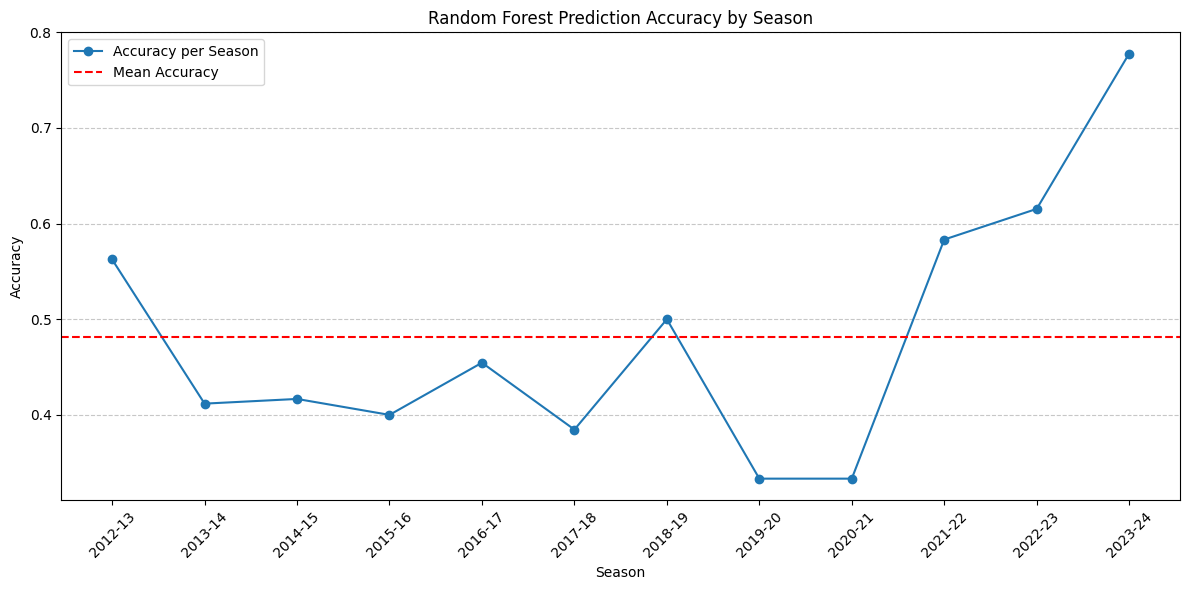

In [ ]:
accuracy_plot(test_res[test_res['MVP_Flag']==1],'MVP_Flag')

In [ ]:
#prep:
df2 = lagged_awards(awards_df,['no_awards', 'MVP_Flag'])
merged_df = pd.merge(df, df2[['Player', 'Season', 'Team','Pos',
                              'no_awards_Lagged',
                              'MVP_Flag_Lagged','MVP_Flag_Cumulative']], on=['Player', 'Season','Team','Pos'], how='left')

#model:
target_var = 'MVP_Flag'
features = ['no_awards_Lagged','MVP_Flag_Lagged','MVP_Flag_Cumulative', "PPG",'APG','RPG','Age',
            'minutes_per_game', 'ppgpm','PF','STL','BLK',]
df = df
train_res, test_res = rf_model(target_var, features, merged_df)

<ipython-input-10-4ba9c027dfb2>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7822
           1       0.75      0.60      0.67       152

    accuracy                           0.99      7974
   macro avg       0.87      0.80      0.83      7974
weighted avg       0.99      0.99      0.99      7974

Confusion Matrix:
[[7792   30]
 [  61   91]]
                Feature  Importance
7      minutes_per_game    0.214724
3                   PPG    0.200074
8                 ppgpm    0.162963
0      no_awards_Lagged    0.083428
2   MVP_Flag_Cumulative    0.081234
4                   APG    0.060977
10                  STL    0.059936
5                   RPG    0.038032
1       MVP_Flag_Lagged    0.031302
9                    PF    0.028625
11                  BLK    0.023094
6                   Age    0.015611


<ipython-input-10-4ba9c027dfb2>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y_pred'] = y_pred
<ipython-input-10-4ba9c027dfb2>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['y_pred'] =   rf.predict(X_train)


<ipython-input-11-8ee996f36389>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_accuracy = df.groupby('Season').apply(


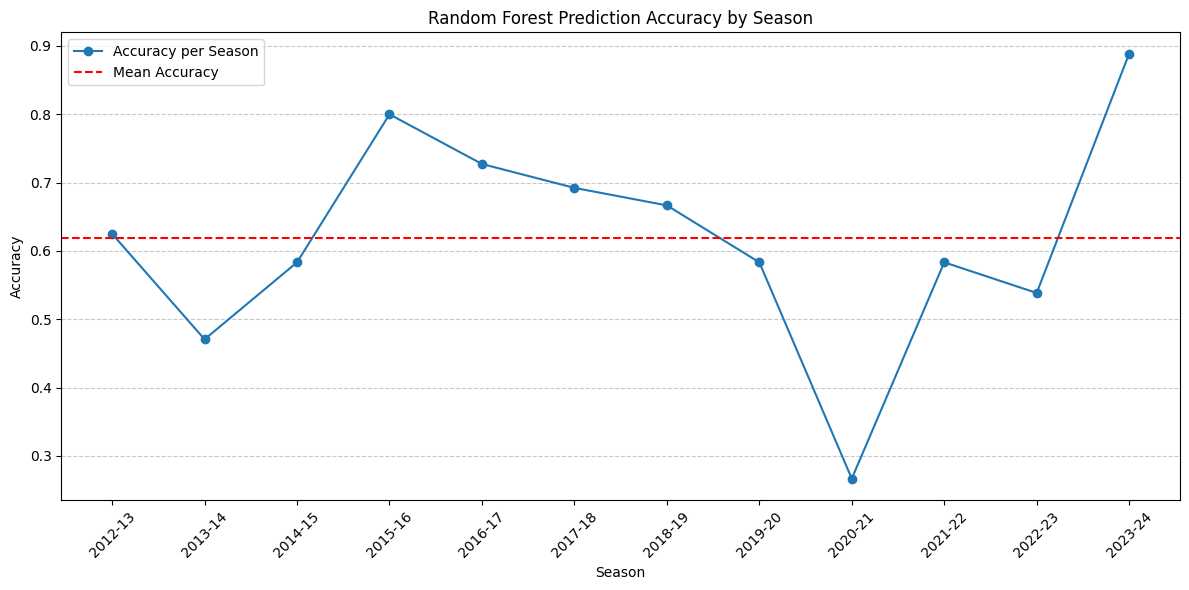

In [ ]:
accuracy_plot(test_res[test_res['MVP_Flag']==1],'MVP_Flag')

# Emma

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
df['MVP_Flag'] = df['Awards_List'].apply(lambda x: 1 if isinstance(x, list) and any('MVP' in award for award in x) else 0)



fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['Players with MVP Label', 'Players without MVP Label'])


mvp_1 = df[df['MVP_Flag'] == 1]
hist_1 = px.histogram(mvp_1, x='eFG%')

fig.add_trace(go.Histogram(x=mvp_1['eFG%'], name='MVP Label', marker_color='blue'), row=1, col=1)


mvp_0 = df[df['MVP_Flag'] == 0]
hist_0 = px.histogram(mvp_0, x='eFG%')


fig.add_trace(go.Histogram(x=mvp_0['eFG%'], name='Players without MVP Label', marker_color='orange'), row=2, col=1)


fig.update_layout(title_text="Distribution of eFG% for players (1955-2024)", showlegend=False,height = 600)


fig.show()


In [ ]:
df['MVP-1'] = df['Awards_List'].apply(lambda x: 'MVP-1' in x if isinstance(x, list) else False)



mvp_winners = df[df['MVP-1'] == True]


mvp_by_position = mvp_winners.groupby('Pos').size().reset_index(name='MVP_Count')


fig = px.bar(mvp_by_position, x='Pos', y='MVP_Count', title='Number of MVP Winners by Position (1955-2024)',
labels = {'Pos':'Position','MVP_Count': '# MVP Winners'})


fig.show()


# Sean

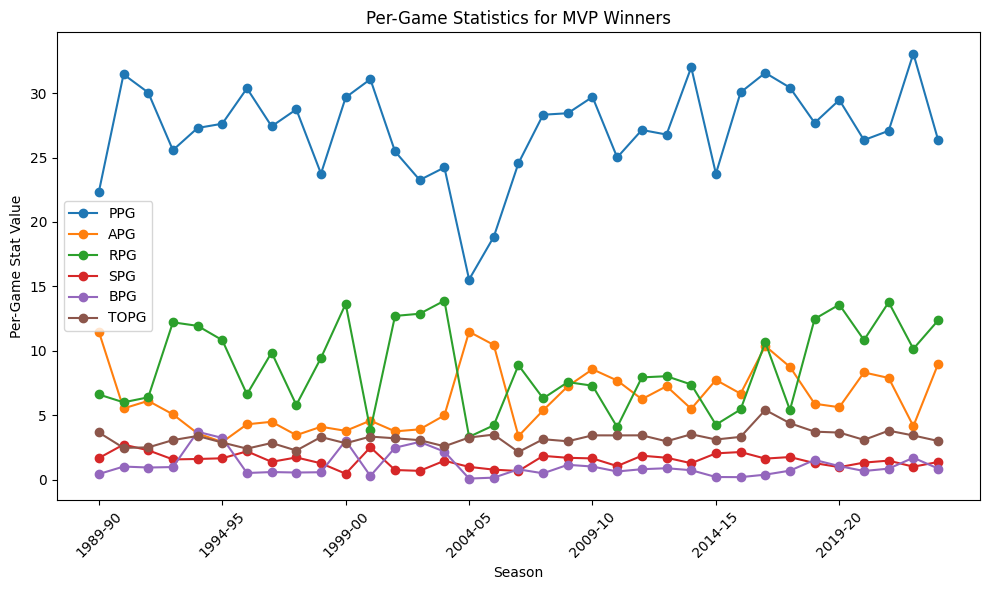

In [ ]:
mvp_winners_df = df[df['Awards_List'].apply(lambda x: 'MVP-1' in x if isinstance(x, list) else False)]
mvp_stats_df = mvp_winners_df[['Season', 'PPG', 'APG', 'RPG', 'SPG', 'BPG', 'TOPG']]
mvp_stats_season = mvp_stats_df.groupby('Season').mean()


plt.figure(figsize=(10, 6))
plt.plot(mvp_stats_season.index, mvp_stats_season['PPG'], label='PPG', marker='o')
plt.plot(mvp_stats_season.index, mvp_stats_season['APG'], label='APG', marker='o')
plt.plot(mvp_stats_season.index, mvp_stats_season['RPG'], label='RPG', marker='o')
plt.plot(mvp_stats_season.index, mvp_stats_season['SPG'], label='SPG', marker='o')
plt.plot(mvp_stats_season.index, mvp_stats_season['BPG'], label='BPG', marker='o')
plt.plot(mvp_stats_season.index, mvp_stats_season['TOPG'], label='TOPG', marker='o')


plt.title('Per-Game Statistics for MVP Winners')
plt.xlabel('Season')
plt.ylabel('Per-Game Stat Value')
plt.legend()


plt.xticks(ticks=mvp_stats_season.index[::5], rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
mvp_vote_getters = df[df['Awards_List'].apply(lambda x: any(award.startswith('MVP-') for award in x) if isinstance(x, list) else False)]
mvp_vote_getters.head()

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,BPG,TOPG,pt_per_minute,minutes_per_game,ppgpm,Pos_lab,MVP_Award_Number,MVP_Label,MVP_Flag,MVP-1
0,1.0,Michael Jordan,26.0,CHI,SG,82.0,82.0,3197.0,1034.0,1964.0,...,0.658537,3.012195,0.861120,38.987805,70.611824,4,3,mvp-3,1,False
1,2.0,Karl Malone,26.0,UTA,PF,82.0,82.0,3122.0,914.0,1627.0,...,0.609756,3.707317,0.813581,38.073171,66.713645,1,4,mvp-4,1,False
2,3.0,Patrick Ewing,27.0,NYK,C,82.0,82.0,3165.0,922.0,1673.0,...,3.987805,3.390244,0.741548,38.597561,60.806951,0,5,mvp-5,1,False
3,4.0,Tom Chambers,30.0,PHO,PF,81.0,81.0,3046.0,810.0,1617.0,...,0.580247,2.691358,0.722587,37.604938,58.529547,1,8,none,1,False
6,7.0,Hakeem Olajuwon,27.0,HOU,C,82.0,82.0,3124.0,806.0,1609.0,...,4.585366,3.853659,0.638604,38.097561,52.365557,0,7,none,1,False


<ipython-input-28-fbb1afcfee9f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-28-fbb1afcfee9f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



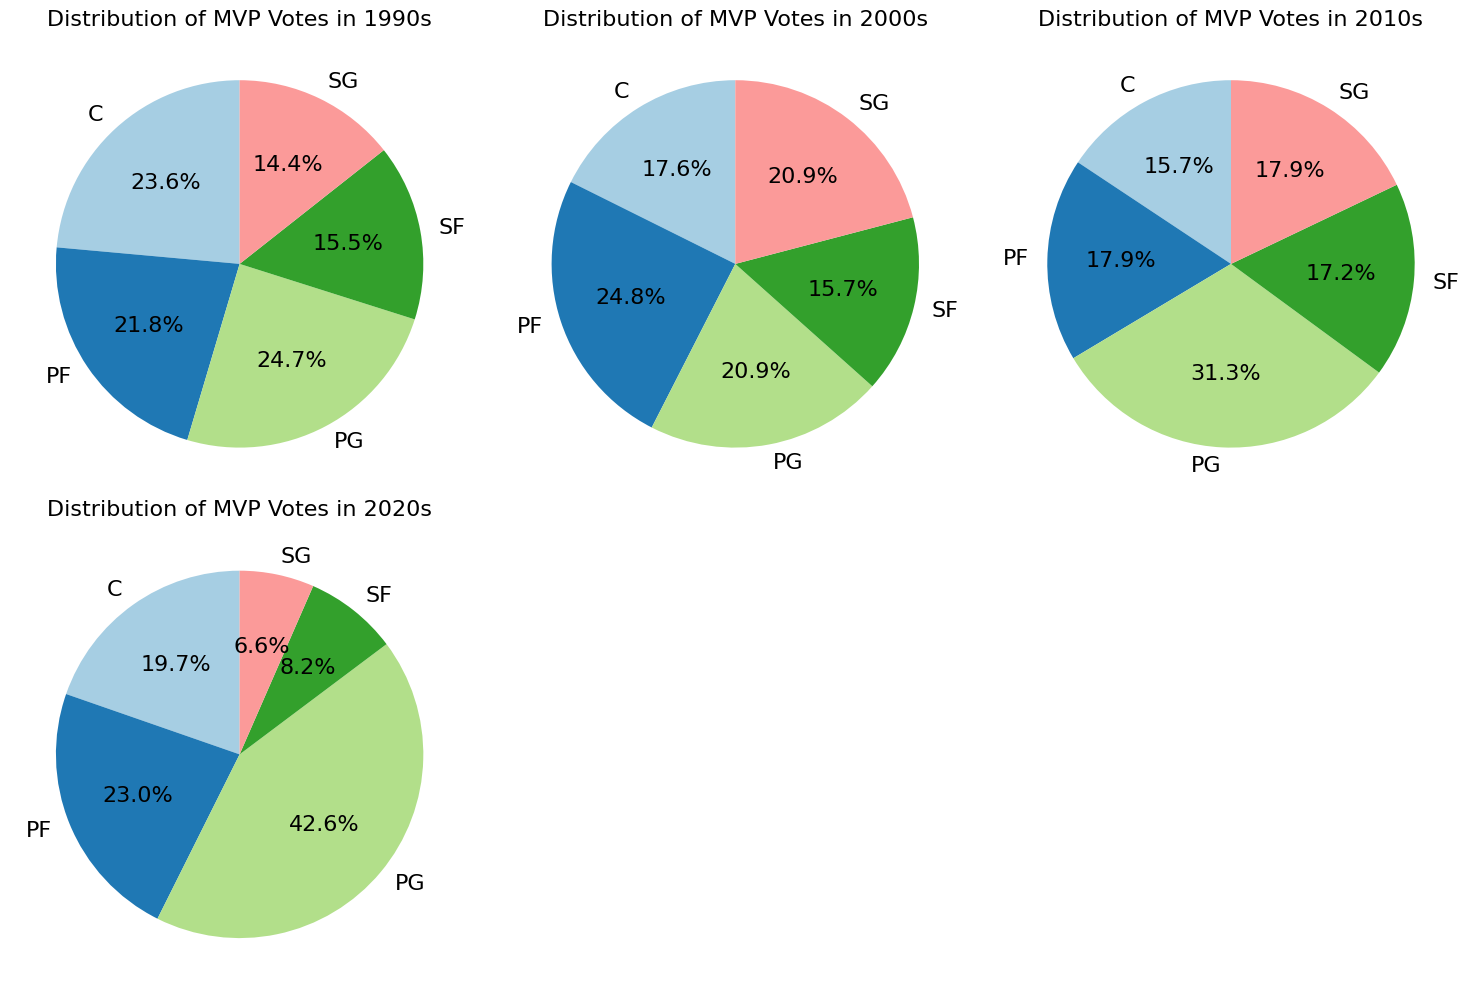

In [ ]:
# Extract the ending year from the 'Season' column
mvp_vote_getters['Ending_Year'] = mvp_vote_getters['Season'].apply(lambda x: int(x.split('-')[1]) + 2000 if int(x.split('-')[1]) < 50 else int(x.split('-')[1]) + 1900)

# Now create the 'Decade' column based on the ending year
mvp_vote_getters['Decade'] = (mvp_vote_getters['Ending_Year'] // 10) * 10

# Group the data by Decade and Pos to get counts of vote-getters by position each decade
position_counts_by_decade = mvp_vote_getters.groupby(['Decade', 'Pos']).size().unstack(fill_value=0)

# Get unique decades
unique_decades = position_counts_by_decade.index.unique()
num_decades = len(unique_decades)

# Define the grid size
cols = 3  # number of columns
rows = (num_decades + cols - 1) // cols  # calculate the number of rows needed

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axs.flatten()

# Loop through decades and plot in the grid
for i, decade in enumerate(unique_decades):
    # Get the position counts for the current decade
    position_counts = position_counts_by_decade.loc[decade]

    # Plot the pie chart with larger percentage labels
    axs[i].pie(position_counts, labels=position_counts.index, autopct='%1.1f%%', startangle=90,
               colors=plt.cm.Paired.colors, textprops={'fontsize': 16})  # Increase font size here
    axs[i].set_title(f'Distribution of MVP Votes in {decade}s', fontsize=16)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')  # Hide unused axes

# Adjust layout
plt.tight_layout()
plt.show()



In [ ]:
df.shape

(20106, 48)